In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import geopandas as gpd

In [2]:
proj_dir = Path('../')
geopackage_fn = proj_dir / 'Data/col_drivt_data.gpkg'

In [3]:
columbia = pd.read_csv(proj_dir / 'Data/LandsatTemperature/columbia_clean.csv')

# Replace "NULL" with NaN and convert LandTempC, NDVI, WaterTempC, ClimateClass, RKm to float
columbia = columbia.replace('NULL', np.nan)
columbia['LandTempC'] = columbia['LandTempC'].astype(float)
columbia['NDVI'] = columbia['NDVI'].astype(float)
columbia['WaterTempC'] = columbia['WaterTempC'].astype(float)
columbia['ClimateClass'] = columbia['ClimateClass'].astype(float)
columbia['RKm'] = columbia['RKm'].astype(float)

# Convert Date to datetime
columbia['Date'] = pd.to_datetime(columbia['Date'])
columbia = columbia[columbia['WaterTempC'] > 0]

columbia.head()

,ReachID,Date,LandTempC,WaterTempC,NDVI,Mission,Name,ClimateClass,RKm
0,42,2022-02-17,3.94372,5.39979,NaN,L9,Columbia_River_1,9.0,0.0
1,42,2022-03-05,11.78180,6.21907,0.168393,L9,Columbia_River_1,9.0,0.0
2,42,2022-04-06,10.65880,4.34301,0.122964,L9,Columbia_River_1,9.0,0.0
3,42,2022-04-22,18.02620,9.56365,0.113320,L9,Columbia_River_1,9.0,0.0
4,42,2022-05-08,18.19150,11.31710,0.176089,L9,Columbia_River_1,9.0,0.0


In [4]:
# read buffered reaches
reaches = gpd.read_file(geopackage_fn, layer='Reaches')
basin = gpd.read_file(geopackage_fn, layer='Basins')

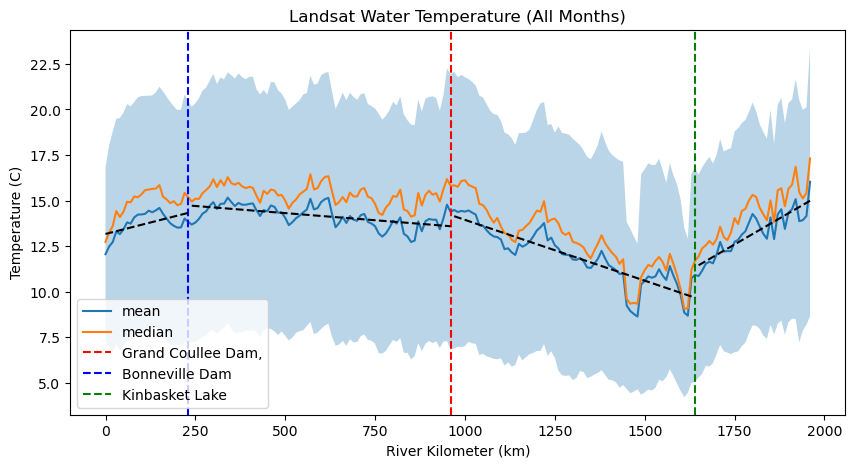

In [5]:
# group by RKm and calculate the mean, std, median, min, max of LandTempC, WaterTempC, ClimateClass
# operation on summer months only
# co = columbia['Date'].dt.month.isin([6, 7, 8])
co = columbia['Date'].dt.month.isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
col_stats = columbia[co].groupby('RKm').agg({'LandTempC': ['mean', 'std', 'median', 'min', 'max'], 'WaterTempC': ['mean', 'std', 'median', 'min', 'max'], 'ClimateClass': ['mean', 'std', 'median', 'min', 'max']})

fig, ax = plt.subplots(figsize=(10, 5))
col_stats['WaterTempC'][['mean','median',]].plot(ax=ax)
ax.fill_between(col_stats.index, col_stats['WaterTempC']['mean'] - col_stats['WaterTempC']['std'], col_stats['WaterTempC']['mean'] + col_stats['WaterTempC']['std'], alpha=0.3)
ax.axvline(x=960, color='r', linestyle='--', label='Grand Coullee Dam,')
# ax.axvline(x=305, color='k', linestyle='--', label='Dalles Dam')
ax.axvline(x=230, color='b', linestyle='--', label='Bonneville Dam')
ax.axvline(x=1640, color='g', linestyle='--', label='Kinbasket Lake')
# ax.axvline(x=870, color='g', linestyle='--')
ax.legend(loc='lower left')
ax.set_xlabel('River Kilometer (km)')
ax.set_ylabel('Temperature (C)')

ax.set_title('Landsat Water Temperature (All Months)')

# find the line of bes fit and plot it
# lower columbia
x_lower = col_stats[col_stats.index <=230].index
y_lower = col_stats[col_stats.index <=230]['WaterTempC']['mean']
m_lower, b_lower = np.polyfit(x_lower, y_lower, 1)
ax.plot(x_lower, m_lower*x_lower + b_lower, color='k', linestyle='--')

# mid columbia
x_middle = col_stats[(col_stats.index >230) & (col_stats.index <=960)].index
y_middle = col_stats[(col_stats.index >230) & (col_stats.index <=960)]['WaterTempC']['mean']
m_mid, b_mid = np.polyfit(x_middle, y_middle, 1)
ax.plot(x_middle, m_mid*x_middle + b_mid, color='k', linestyle='--')

# upper columbia -1st part up to kinbasket lake
x_upper1 = col_stats[(col_stats.index >960) & (col_stats.index <=1640)].index
y_upper1 = col_stats[(col_stats.index >960) & (col_stats.index <=1640)]['WaterTempC']['mean']
m_upper1, b_upper1 = np.polyfit(x_upper1, y_upper1, 1)
ax.plot(x_upper1, m_upper1*x_upper1 + b_upper1, color='k', linestyle='--')

# upper columbia -2nd part after kinbasket lake
x_upper2 = col_stats[col_stats.index >1640].index
y_upper2 = col_stats[col_stats.index >1640]['WaterTempC']['mean']
m_upper2, b_upper2 = np.polyfit(x_upper2, y_upper2, 1)
ax.plot(x_upper2, m_upper2*x_upper2 + b_upper2, color='k', linestyle='--');



In [6]:
# print the slopes
print(f'Lower Columbia Slope: {-m_lower*10:.2f}' )
print(f'Mid Columbia Slope: {-m_mid*10:.2f}' )
print(f'Upper Columbia Slope: {-m_upper1*10:.2f}' )
print(f'Upper Columbia Slope: {-m_upper2*10:.2f}' )

Lower Columbia Slope: -0.05
Mid Columbia Slope: 0.02
Upper Columbia Slope: 0.07
Upper Columbia Slope: -0.11


In [7]:
col_stats['WaterTempC'].min()

mean       8.637769
std        3.995075
median     9.068400
min        0.001031
max       20.832900
dtype: float64

Text(55.99665809883588, 0.5, 'Latitude (deg)')

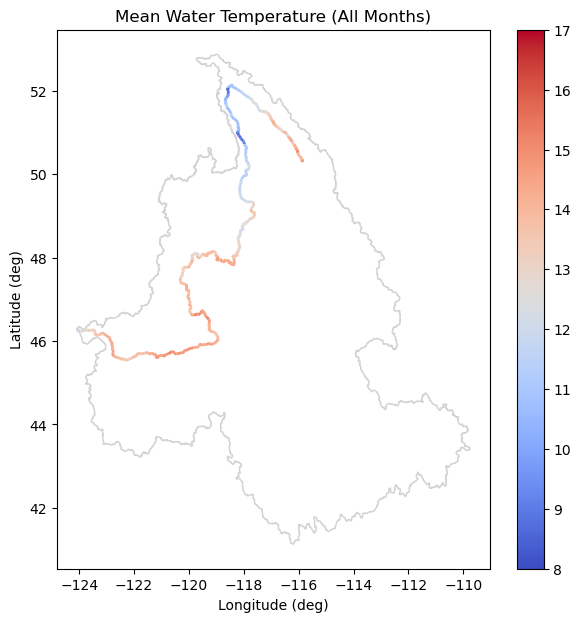

In [8]:

fig, ax = plt.subplots(figsize=(7, 7))
basin.plot(ax=ax, facecolor='none', edgecolor='lightgray')
m=reaches.merge(col_stats['WaterTempC'].reset_index(), on='RKm').plot(column='mean', legend=True, ax=ax, vmin=8, vmax=17,
                                                                             cmap='coolwarm', linewidth=2)
ax.set_title('Mean Water Temperature (All Months)')
ax.set_xlabel('Longitude (deg)')
ax.set_ylabel('Latitude (deg)')

# fig.colorbar(m, ax=ax, label='WaterTemperature (C)')

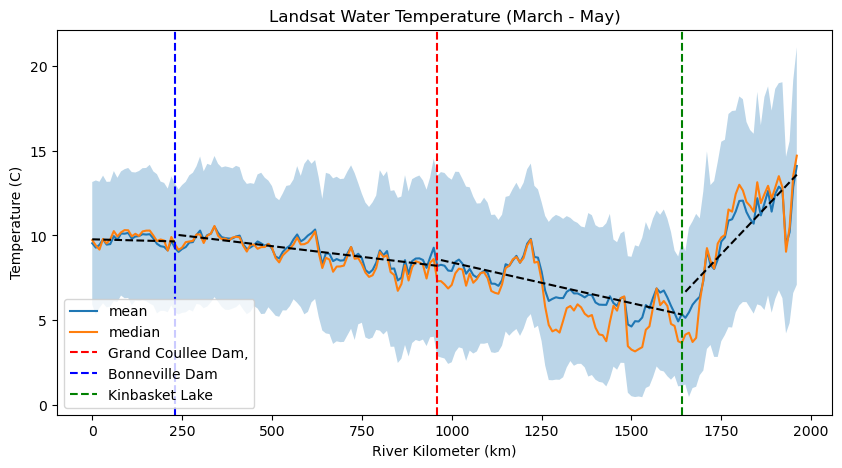

In [9]:
# group by RKm and calculate the mean, std, median, min, max of LandTempC, WaterTempC, ClimateClass
# operation on summer months only
# co = columbia['Date'].dt.month.isin([6, 7, 8])
co = columbia['Date'].dt.month.isin([3, 4, 5])
col_stats = columbia[co].groupby('RKm').agg({'LandTempC': ['mean', 'std', 'median', 'min', 'max'], 'WaterTempC': ['mean', 'std', 'median', 'min', 'max'], 'ClimateClass': ['mean', 'std', 'median', 'min', 'max']})

fig, ax = plt.subplots(figsize=(10, 5))
col_stats['WaterTempC'][['mean','median',]].plot(ax=ax)
ax.fill_between(col_stats.index, col_stats['WaterTempC']['mean'] - col_stats['WaterTempC']['std'], col_stats['WaterTempC']['mean'] + col_stats['WaterTempC']['std'], alpha=0.3)
ax.axvline(x=960, color='r', linestyle='--', label='Grand Coullee Dam,')
# ax.axvline(x=305, color='k', linestyle='--', label='Dalles Dam')
ax.axvline(x=230, color='b', linestyle='--', label='Bonneville Dam')
ax.axvline(x=1640, color='g', linestyle='--', label='Kinbasket Lake')
# ax.axvline(x=870, color='g', linestyle='--')
ax.legend(loc='lower left')
ax.set_xlabel('River Kilometer (km)')
ax.set_ylabel('Temperature (C)')

ax.set_title('Landsat Water Temperature (March - May)')

# find the line of bes fit and plot it
# lower columbia
x_lower = col_stats[col_stats.index <=230].index
y_lower = col_stats[col_stats.index <=230]['WaterTempC']['mean']
m_lower, b_lower = np.polyfit(x_lower, y_lower, 1)
ax.plot(x_lower, m_lower*x_lower + b_lower, color='k', linestyle='--')

# mid columbia
x_middle = col_stats[(col_stats.index >230) & (col_stats.index <=960)].index
y_middle = col_stats[(col_stats.index >230) & (col_stats.index <=960)]['WaterTempC']['mean']
m_mid, b_mid = np.polyfit(x_middle, y_middle, 1)
ax.plot(x_middle, m_mid*x_middle + b_mid, color='k', linestyle='--')

# upper columbia -1st part up to kinbasket lake
x_upper1 = col_stats[(col_stats.index >960) & (col_stats.index <=1640)].index
y_upper1 = col_stats[(col_stats.index >960) & (col_stats.index <=1640)]['WaterTempC']['mean']
m_upper1, b_upper1 = np.polyfit(x_upper1, y_upper1, 1)
ax.plot(x_upper1, m_upper1*x_upper1 + b_upper1, color='k', linestyle='--')

# upper columbia -2nd part after kinbasket lake
x_upper2 = col_stats[col_stats.index >1640].index
y_upper2 = col_stats[col_stats.index >1640]['WaterTempC']['mean']
m_upper2, b_upper2 = np.polyfit(x_upper2, y_upper2, 1)
ax.plot(x_upper2, m_upper2*x_upper2 + b_upper2, color='k', linestyle='--');



In [10]:
# print the slopes
print(f'Lower Columbia Slope: {-m_lower*10:.2f}' )
print(f'Mid Columbia Slope: {-m_mid*10:.2f}' )
print(f'Upper Columbia Slope: {-m_upper1*10:.2f}' )
print(f'Upper Columbia Slope: {-m_upper2*10:.2f}' )

Lower Columbia Slope: 0.01
Mid Columbia Slope: 0.03
Upper Columbia Slope: 0.05
Upper Columbia Slope: -0.22


In [11]:
col_stats['WaterTempC'].max()

mean      14.088211
std        6.992247
median    14.695950
min        2.047240
max       70.215700
dtype: float64

Text(55.99665809883588, 0.5, 'Latitude (deg)')

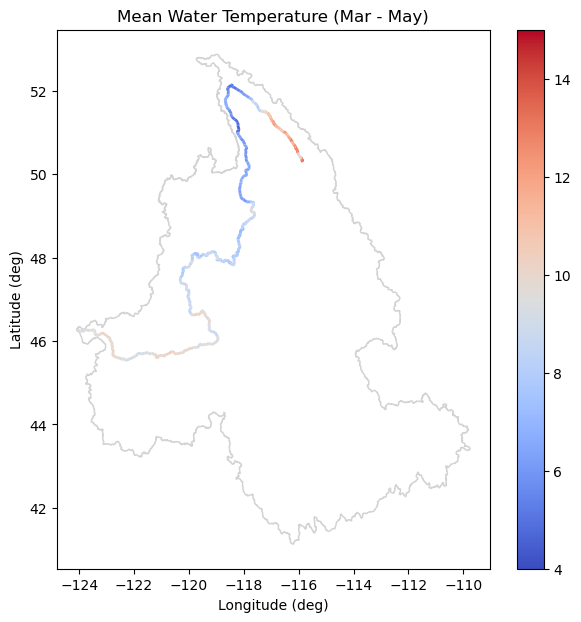

In [12]:

fig, ax = plt.subplots(figsize=(7, 7))
basin.plot(ax=ax, facecolor='none', edgecolor='lightgray')
m=reaches.merge(col_stats['WaterTempC'].reset_index(), on='RKm').plot(column='mean', legend=True, ax=ax, vmin=4, vmax=15,
                                                                             cmap='coolwarm', linewidth=2)
ax.set_title('Mean Water Temperature (Mar - May)')
ax.set_xlabel('Longitude (deg)')
ax.set_ylabel('Latitude (deg)')

# fig.colorbar(m, ax=ax, label='Water Temperature (C)')

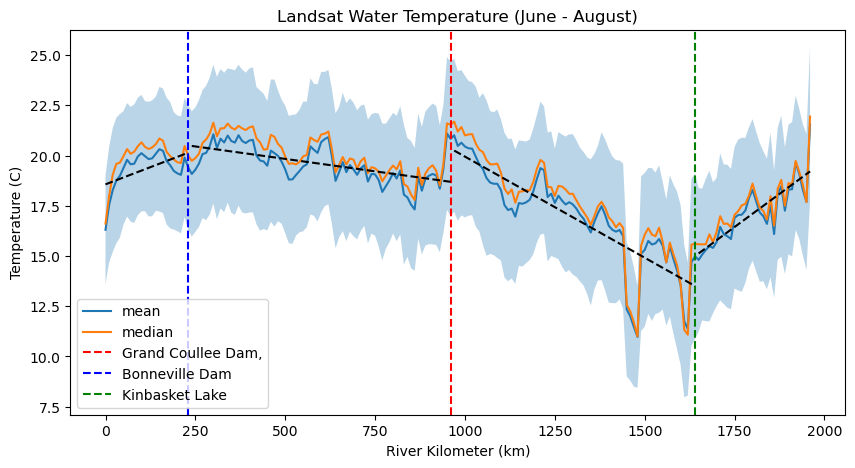

In [13]:
# group by RKm and calculate the mean, std, median, min, max of LandTempC, WaterTempC, ClimateClass
# operation on summer months only
# co = columbia['Date'].dt.month.isin([6, 7, 8])
co = columbia['Date'].dt.month.isin([6, 7, 8])
col_stats = columbia[co].groupby('RKm').agg({'LandTempC': ['mean', 'std', 'median', 'min', 'max'], 'WaterTempC': ['mean', 'std', 'median', 'min', 'max'], 'ClimateClass': ['mean', 'std', 'median', 'min', 'max']})

fig, ax = plt.subplots(figsize=(10, 5))
col_stats['WaterTempC'][['mean','median',]].plot(ax=ax)
ax.fill_between(col_stats.index, col_stats['WaterTempC']['mean'] - col_stats['WaterTempC']['std'], col_stats['WaterTempC']['mean'] + col_stats['WaterTempC']['std'], alpha=0.3)
ax.axvline(x=960, color='r', linestyle='--', label='Grand Coullee Dam,')
# ax.axvline(x=305, color='k', linestyle='--', label='Dalles Dam')
ax.axvline(x=230, color='b', linestyle='--', label='Bonneville Dam')
ax.axvline(x=1640, color='g', linestyle='--', label='Kinbasket Lake')
# ax.axvline(x=870, color='g', linestyle='--')
ax.legend(loc='lower left')
ax.set_xlabel('River Kilometer (km)')
ax.set_ylabel('Temperature (C)')

ax.set_title('Landsat Water Temperature (June - August)')

# find the line of bes fit and plot it
# lower columbia
x_lower = col_stats[col_stats.index <=230].index
y_lower = col_stats[col_stats.index <=230]['WaterTempC']['mean']
m_lower, b_lower = np.polyfit(x_lower, y_lower, 1)
ax.plot(x_lower, m_lower*x_lower + b_lower, color='k', linestyle='--')

# mid columbia
x_middle = col_stats[(col_stats.index >230) & (col_stats.index <=960)].index
y_middle = col_stats[(col_stats.index >230) & (col_stats.index <=960)]['WaterTempC']['mean']
m_mid, b_mid = np.polyfit(x_middle, y_middle, 1)
ax.plot(x_middle, m_mid*x_middle + b_mid, color='k', linestyle='--')

# upper columbia -1st part up to kinbasket lake
x_upper1 = col_stats[(col_stats.index >960) & (col_stats.index <=1640)].index
y_upper1 = col_stats[(col_stats.index >960) & (col_stats.index <=1640)]['WaterTempC']['mean']
m_upper1, b_upper1 = np.polyfit(x_upper1, y_upper1, 1)
ax.plot(x_upper1, m_upper1*x_upper1 + b_upper1, color='k', linestyle='--')

# upper columbia -2nd part after kinbasket lake
x_upper2 = col_stats[col_stats.index >1640].index
y_upper2 = col_stats[col_stats.index >1640]['WaterTempC']['mean']
m_upper2, b_upper2 = np.polyfit(x_upper2, y_upper2, 1)
ax.plot(x_upper2, m_upper2*x_upper2 + b_upper2, color='k', linestyle='--');



In [14]:
# print the slopes
print(f'Lower Columbia Slope: {-m_lower*10:.2f}' )
print(f'Mid Columbia Slope: {-m_mid*10:.2f}' )
print(f'Upper Columbia Slope: {-m_upper1*10:.2f}' )
print(f'Upper Columbia Slope: {-m_upper2*10:.2f}' )

Lower Columbia Slope: -0.07
Mid Columbia Slope: 0.02
Upper Columbia Slope: 0.10
Upper Columbia Slope: -0.13


In [15]:
col_stats['WaterTempC'].max()

mean      21.554735
std        4.149869
median    21.943000
min       10.950700
max       44.394300
dtype: float64

Text(55.99665809883588, 0.5, 'Latitude (deg)')

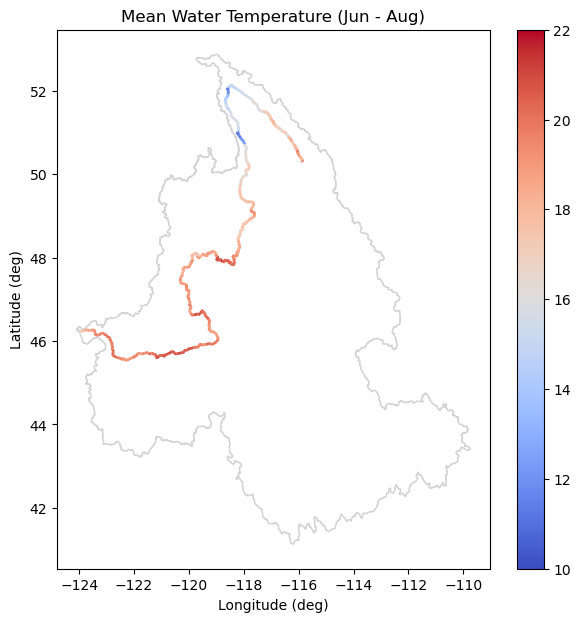

In [16]:

fig, ax = plt.subplots(figsize=(7, 7))
basin.plot(ax=ax, facecolor='none', edgecolor='lightgray')
m = reaches.merge(col_stats['WaterTempC'].reset_index(), on='RKm').plot(column='mean', legend=True, ax=ax, vmin=10, vmax=22,
                                                                             cmap='coolwarm', linewidth=2)
ax.set_title('Mean Water Temperature (Jun - Aug)')
ax.set_xlabel('Longitude (deg)')
ax.set_ylabel('Latitude (deg)')

# fig.colorbar(m, ax=ax, label='Water Temperature (C)')

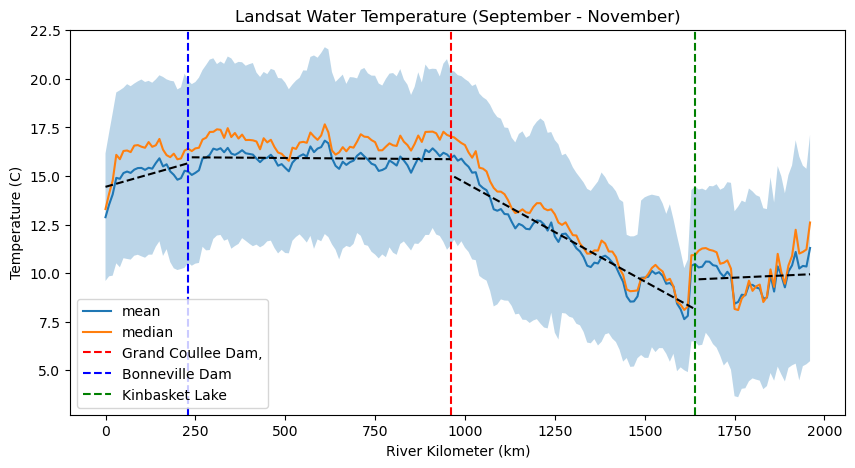

In [17]:
# group by RKm and calculate the mean, std, median, min, max of LandTempC, WaterTempC, ClimateClass
# operation on summer months only
# co = columbia['Date'].dt.month.isin([6, 7, 8])
co = columbia['Date'].dt.month.isin([9, 10, 11])
col_stats = columbia[co].groupby('RKm').agg({'LandTempC': ['mean', 'std', 'median', 'min', 'max'], 'WaterTempC': ['mean', 'std', 'median', 'min', 'max'], 'ClimateClass': ['mean', 'std', 'median', 'min', 'max']})

fig, ax = plt.subplots(figsize=(10, 5))
col_stats['WaterTempC'][['mean','median',]].plot(ax=ax)
ax.fill_between(col_stats.index, col_stats['WaterTempC']['mean'] - col_stats['WaterTempC']['std'], col_stats['WaterTempC']['mean'] + col_stats['WaterTempC']['std'], alpha=0.3)
ax.axvline(x=960, color='r', linestyle='--', label='Grand Coullee Dam,')
# ax.axvline(x=305, color='k', linestyle='--', label='Dalles Dam')
ax.axvline(x=230, color='b', linestyle='--', label='Bonneville Dam')
ax.axvline(x=1640, color='g', linestyle='--', label='Kinbasket Lake')
# ax.axvline(x=870, color='g', linestyle='--')
ax.legend(loc='lower left')
ax.set_xlabel('River Kilometer (km)')
ax.set_ylabel('Temperature (C)')

ax.set_title('Landsat Water Temperature (September - November)')

# find the line of bes fit and plot it
# lower columbia
x_lower = col_stats[col_stats.index <=230].index
y_lower = col_stats[col_stats.index <=230]['WaterTempC']['mean']
m_lower, b_lower = np.polyfit(x_lower, y_lower, 1)
ax.plot(x_lower, m_lower*x_lower + b_lower, color='k', linestyle='--')

# mid columbia
x_middle = col_stats[(col_stats.index >230) & (col_stats.index <=960)].index
y_middle = col_stats[(col_stats.index >230) & (col_stats.index <=960)]['WaterTempC']['mean']
m_mid, b_mid = np.polyfit(x_middle, y_middle, 1)
ax.plot(x_middle, m_mid*x_middle + b_mid, color='k', linestyle='--')

# upper columbia -1st part up to kinbasket lake
x_upper1 = col_stats[(col_stats.index >960) & (col_stats.index <=1640)].index
y_upper1 = col_stats[(col_stats.index >960) & (col_stats.index <=1640)]['WaterTempC']['mean']
m_upper1, b_upper1 = np.polyfit(x_upper1, y_upper1, 1)
ax.plot(x_upper1, m_upper1*x_upper1 + b_upper1, color='k', linestyle='--')

# upper columbia -2nd part after kinbasket lake
x_upper2 = col_stats[col_stats.index >1640].index
y_upper2 = col_stats[col_stats.index >1640]['WaterTempC']['mean']
m_upper2, b_upper2 = np.polyfit(x_upper2, y_upper2, 1)
ax.plot(x_upper2, m_upper2*x_upper2 + b_upper2, color='k', linestyle='--');



In [18]:
# print the slopes
print(f'Lower Columbia Slope: {-m_lower*10:.2f}' )
print(f'Mid Columbia Slope: {-m_mid*10:.2f}' )
print(f'Upper Columbia Slope: {-m_upper1*10:.2f}' )
print(f'Upper Columbia Slope: {-m_upper2*10:.2f}' )

Lower Columbia Slope: -0.05
Mid Columbia Slope: 0.00
Upper Columbia Slope: 0.10
Upper Columbia Slope: -0.01


In [19]:
col_stats['WaterTempC'].max()

mean      16.821427
std        5.824003
median    17.659400
min        4.490600
max       33.348900
dtype: float64

Text(55.99665809883588, 0.5, 'Latitude (deg)')

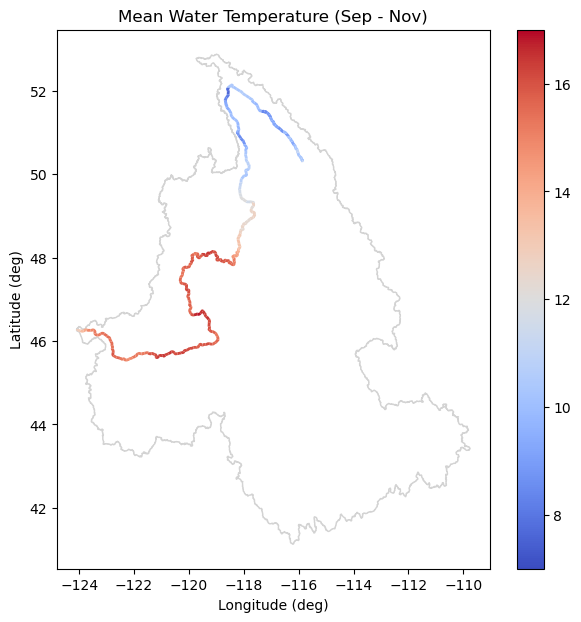

In [20]:

fig, ax = plt.subplots(figsize=(7, 7))
basin.plot(ax=ax, facecolor='none', edgecolor='lightgray')
m=reaches.merge(col_stats['WaterTempC'].reset_index(), on='RKm').plot(column='mean', legend=True, ax=ax, vmin=7, vmax=17,
                                                                             cmap='coolwarm', linewidth=2)
ax.set_title('Mean Water Temperature (Sep - Nov)')
ax.set_xlabel('Longitude (deg)')
ax.set_ylabel('Latitude (deg)')

# fig.colorbar(m, ax=ax, label='Water Temperature (C)')

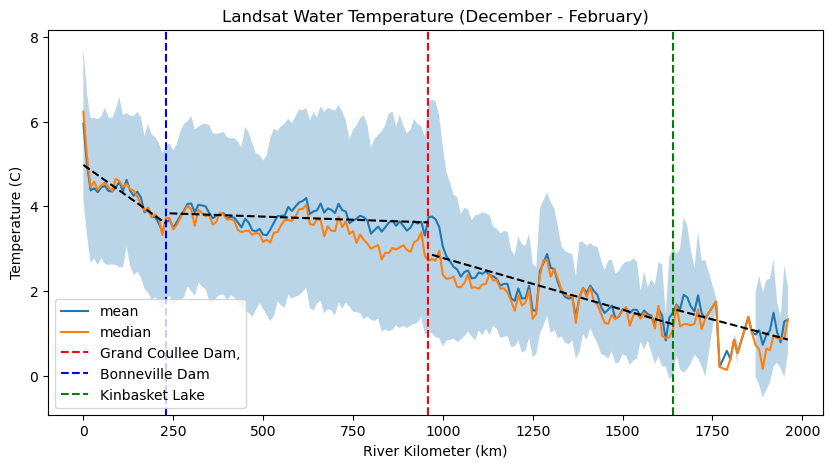

In [21]:
# group by RKm and calculate the mean, std, median, min, max of LandTempC, WaterTempC, ClimateClass
# operation on summer months only
# co = columbia['Date'].dt.month.isin([6, 7, 8])
co = columbia['Date'].dt.month.isin([ 12, 1, 2])
col_stats = columbia[co].groupby('RKm').agg({'LandTempC': ['mean', 'std', 'median', 'min', 'max'], 'WaterTempC': ['mean', 'std', 'median', 'min', 'max'], 'ClimateClass': ['mean', 'std', 'median', 'min', 'max']})

fig, ax = plt.subplots(figsize=(10, 5))
col_stats['WaterTempC'][['mean','median',]].plot(ax=ax)
ax.fill_between(col_stats.index, col_stats['WaterTempC']['mean'] - col_stats['WaterTempC']['std'], col_stats['WaterTempC']['mean'] + col_stats['WaterTempC']['std'], alpha=0.3)
ax.axvline(x=960, color='r', linestyle='--', label='Grand Coullee Dam,')
# ax.axvline(x=305, color='k', linestyle='--', label='Dalles Dam')
ax.axvline(x=230, color='b', linestyle='--', label='Bonneville Dam')
ax.axvline(x=1640, color='g', linestyle='--', label='Kinbasket Lake')
# ax.axvline(x=870, color='g', linestyle='--')
ax.legend(loc='lower left')
ax.set_xlabel('River Kilometer (km)')
ax.set_ylabel('Temperature (C)')

ax.set_title('Landsat Water Temperature (December - February)')

# find the line of bes fit and plot it
# lower columbia
x_lower = col_stats[col_stats.index <=230].index
y_lower = col_stats[col_stats.index <=230]['WaterTempC']['mean']
m_lower, b_lower = np.polyfit(x_lower, y_lower, 1)
ax.plot(x_lower, m_lower*x_lower + b_lower, color='k', linestyle='--')

# mid columbia
x_middle = col_stats[(col_stats.index >230) & (col_stats.index <=960)].index
y_middle = col_stats[(col_stats.index >230) & (col_stats.index <=960)]['WaterTempC']['mean']
m_mid, b_mid = np.polyfit(x_middle, y_middle, 1)
ax.plot(x_middle, m_mid*x_middle + b_mid, color='k', linestyle='--')

# upper columbia -1st part up to kinbasket lake
x_upper1 = col_stats[(col_stats.index >960) & (col_stats.index <=1640)].index
y_upper1 = col_stats[(col_stats.index >960) & (col_stats.index <=1640)]['WaterTempC']['mean']
m_upper1, b_upper1 = np.polyfit(x_upper1, y_upper1, 1)
ax.plot(x_upper1, m_upper1*x_upper1 + b_upper1, color='k', linestyle='--')

# upper columbia -2nd part after kinbasket lake
x_upper2 = col_stats[col_stats.index >1640].index
y_upper2 = col_stats[col_stats.index >1640]['WaterTempC']['mean']
m_upper2, b_upper2 = np.polyfit(x_upper2, y_upper2, 1)
ax.plot(x_upper2, m_upper2*x_upper2 + b_upper2, color='k', linestyle='--');



In [22]:
# print the slopes
print(f'Lower Columbia Slope: {-m_lower*10:.2f}' )
print(f'Mid Columbia Slope: {-m_mid*10:.2f}' )
print(f'Upper Columbia Slope: {-m_upper1*10:.2f}' )
print(f'Upper Columbia Slope: {-m_upper2*10:.2f}' )

Lower Columbia Slope: 0.06
Mid Columbia Slope: 0.00
Upper Columbia Slope: 0.02
Upper Columbia Slope: 0.02


In [23]:
col_stats['WaterTempC'].max()

mean       5.953987
std        2.785367
median     6.238270
min        1.684410
max       11.853000
dtype: float64

Text(55.99665809883588, 0.5, 'Latitude (deg)')

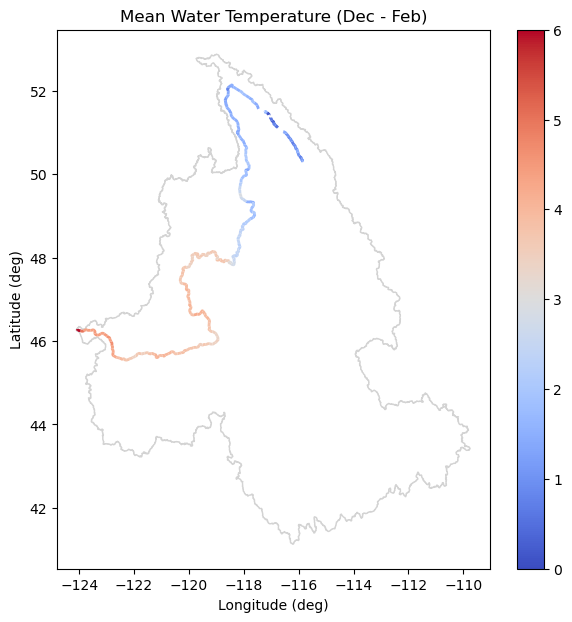

In [24]:

fig, ax = plt.subplots(figsize=(7, 7))
basin.plot(ax=ax, facecolor='none', edgecolor='lightgray')
m=reaches.merge(col_stats['WaterTempC'].reset_index(), on='RKm').plot(column='mean', legend=True, ax=ax, vmin=0, vmax=6,
                                                                             cmap='coolwarm', linewidth=2)
ax.set_title('Mean Water Temperature (Dec - Feb)')
ax.set_xlabel('Longitude (deg)')
ax.set_ylabel('Latitude (deg)')

# fig.colorbar(m, ax=ax, label='Water Temperature (C)')